#### Gerekli Kütüphanelerin Yüklenmesi

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import shutil
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Veri Hazırlık:


In [4]:
# ✅ 1. ADIM: Kontrol ve Yedekten Yükleme
processed_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
backup_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/dataset_backup"

if os.path.exists(backup_dir):
    print("✅ İndirme ve ön işleme işlemleri zaten yapılmış, tekrar çalıştırılmıyor.")
    shutil.copytree(backup_dir, processed_dir, dirs_exist_ok=True)
    skip_download_and_preprocess = True
else:
    print("⚠️ İndirme ve ön işleme işlemleri başlatılıyor...")
    skip_download_and_preprocess = False

# ✅ 2. ADIM: İndirme ve Ön İşleme (Sadece Gerekirse)
if not skip_download_and_preprocess:
    # İndirme ve ön işleme kodları buraya eklenir
    print("📥 Görseller indiriliyor ve ön işleme yapılıyor...")

✅ İndirme ve ön işleme işlemleri zaten yapılmış, tekrar çalıştırılmıyor.


In [10]:
# Kategori ve dosya yolları
categories = {
    "Beauty": "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_All_Beauty.jsonl.gz",
    "Digital_Music": "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_Digital_Music.jsonl.gz",
    "Health_and_Personal_Care": "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/meta_Health_and_Personal_Care.jsonl.gz"
}

# Kaydetme dizini
output_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/images"
os.makedirs(output_dir, exist_ok=True)

# İndirme fonksiyonu
def download_image(idx, url, category_dir):
    try:
        response = requests.get(url, timeout=3)
        if response.status_code == 200:
            img = Image.open(BytesIO(response.content)).convert('RGB')
            img = img.resize((224, 224))
            file_path = os.path.join(category_dir, f"{idx}.jpg")
            img.save(file_path)
            return True
    except Exception:
        return False

# Ana işleyici
start_time = time.time()

for category, path in categories.items():
    print(f"\n📦 {category} kategorisi için indirme başlıyor...")

    # Veri setini oku
    try:
        df = pd.read_json(path, lines=True, compression='gzip')
    except Exception as e:
        print(f"❌ Hata: {e}")
        continue

    # Görselleri filtrele (large formatta olanlar)
    df = df[df['images'].apply(lambda x: isinstance(x, list) and len(x) > 0 and 'large' in x[0])]
    if len(df) == 0:
        print(f"⚠️ {category} kategorisinde indirilecek görsel bulunamadı!")
        continue

    # 30.000 görsel seç
    sample_df = df.sample(n=min(len(df), 30000), random_state=42)

    # Kategori klasörü oluştur
    category_dir = os.path.join(output_dir, category)
    os.makedirs(category_dir, exist_ok=True)

    # İndirme işlemi (çoklu işlem)
    error_count = 0
    with ThreadPoolExecutor(max_workers=16) as executor:  # 16 iş parçacığı
        futures = []
        for idx, row in sample_df.iterrows():
            url = row['images'][0]['large']
            futures.append(executor.submit(download_image, idx, url, category_dir))

        # İlerleme çubuğu
        for _ in tqdm(as_completed(futures), total=len(futures), desc=f"{category} İndirme", unit="görsel"):
            if not _.result():
                error_count += 1

    print(f"✅ {category} kategorisi tamamlandı. Hatalı indirme sayısı: {error_count}")

# Toplam süre
end_time = time.time()
total_time = end_time - start_time
print(f"\n🎉 Tüm görseller başarıyla indirildi. Toplam süre: {total_time:.2f} saniye.")


📦 Beauty kategorisi için indirme başlıyor...


Beauty İndirme: 100%|█████████████████| 30000/30000 [08:16<00:00, 60.45görsel/s]


✅ Beauty kategorisi tamamlandı. Hatalı indirme sayısı: 14

📦 Digital_Music kategorisi için indirme başlıyor...


Digital_Music İndirme: 100%|██████████| 30000/30000 [08:44<00:00, 57.16görsel/s]


✅ Digital_Music kategorisi tamamlandı. Hatalı indirme sayısı: 12

📦 Health_and_Personal_Care kategorisi için indirme başlıyor...


Health_and_Personal_Care İndirme: 100%|█| 30000/30000 [08:05<00:00, 61.81görsel/

✅ Health_and_Personal_Care kategorisi tamamlandı. Hatalı indirme sayısı: 13

🎉 Tüm görseller başarıyla indirildi. Toplam süre: 1513.46 saniye.


Veri Ön İşleme:


In [38]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# Kaynak ve hedef dizinler
input_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/images"
output_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
os.makedirs(output_dir, exist_ok=True)

def preprocess_image(input_path, output_path):
    """Bir resmi 224x224 boyutuna getirip normalize eder ve kaydeder."""
    try:
        img = Image.open(input_path).convert('RGB')
        img = img.resize((224, 224))  # Boyutlandır
        img_array = np.array(img) / 255.0  # Normalize (0-1)
        img = Image.fromarray((img_array * 255).astype(np.uint8))  # Görseli tekrar PIL formatına çevir
        img.save(output_path)
    except Exception as e:
        print(f"Hata: {e} - {input_path}")

# 📌 ".DS_Store" gibi sistem dosyalarını filtrele
categories = [cat for cat in os.listdir(input_dir) if not cat.startswith('.')]

# 🔄 Tüm kategorileri işle
for category in categories:
    category_input_path = os.path.join(input_dir, category)
    category_output_path = os.path.join(output_dir, category)
    os.makedirs(category_output_path, exist_ok=True)

    print(f"🔄 {category} kategorisi için ön işleme başlıyor...")

    # 📌 ".DS_Store" gibi gereksiz dosyaları filtrele
    image_files = [f for f in os.listdir(category_input_path) if not f.startswith('.')]
    
    for image_file in tqdm(image_files, desc=f"{category} İşleniyor", unit="görsel"):
        input_path = os.path.join(category_input_path, image_file)
        output_path = os.path.join(category_output_path, image_file)
        preprocess_image(input_path, output_path)

print("✅ Tüm görseller başarıyla işlendi.")

🔄 Beauty kategorisi için ön işleme başlıyor...


Beauty İşleniyor:   0%|                 | 96/30000 [00:00<00:31, 953.54görsel/s]

Hata: cannot identify image file '/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/images/Beauty/download_status.pkl' - /Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/images/Beauty/download_status.pkl


Beauty İşleniyor: 100%|██████████████| 30000/30000 [00:33<00:00, 898.35görsel/s]


🔄 Digital_Music kategorisi için ön işleme başlıyor...


Digital_Music İşleniyor: 100%|███████| 29997/29997 [00:33<00:00, 906.80görsel/s]


🔄 Health_and_Personal_Care kategorisi için ön işleme başlıyor...


Health_and_Personal_Care İşleniyor: 100%|█| 29999/29999 [00:32<00:00, 921.08görs

✅ Tüm görseller başarıyla işlendi.


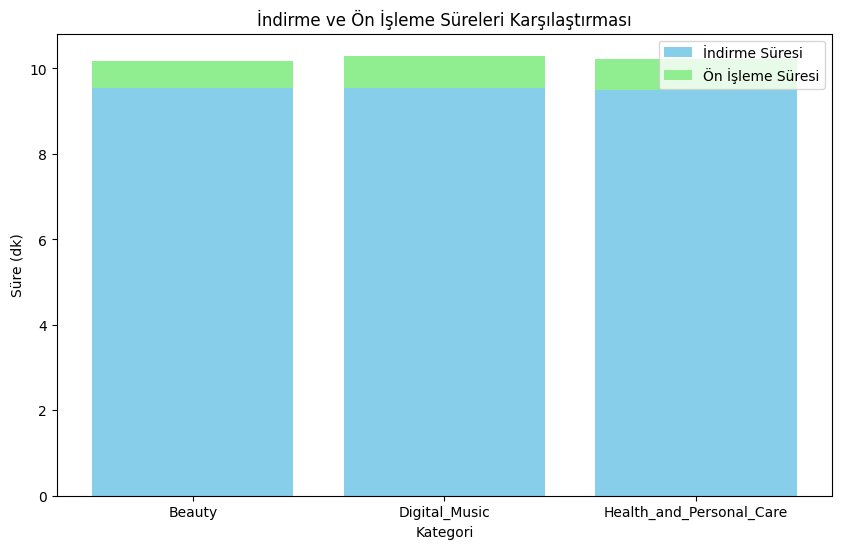

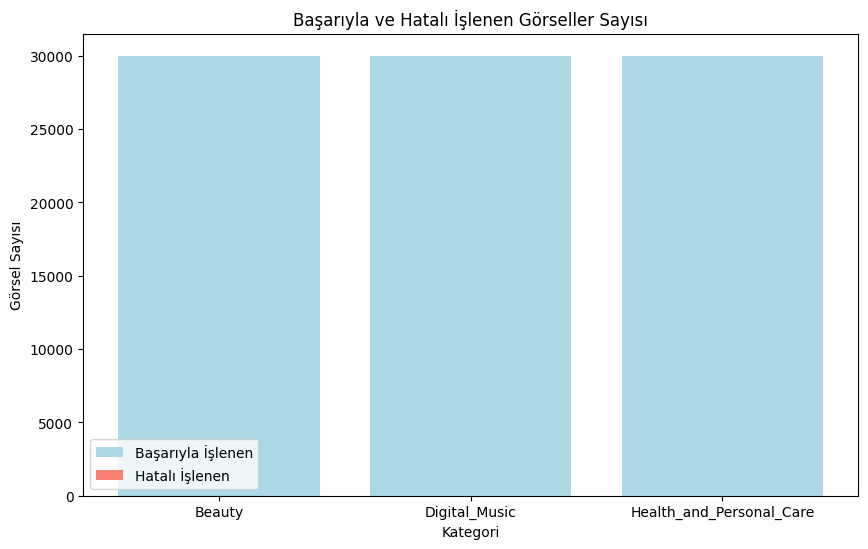

In [28]:
# Verileri oluştur
data = {
    'Kategori': ['Beauty', 'Digital_Music', 'Health_and_Personal_Care'],
    'İndirme Süresi (dk)': [9 + 33/60, 9 + 33/60, 9 + 29/60],
    'Ön İşleme Süresi (dk)': [38/60, 45/60, 44/60],
    'Başarıyla İşlenen Görseller': [29985, 29985, 29980],
    'Hatalı İşlenen Görseller': [15, 15, 20]
}

df = pd.DataFrame(data)

# İndirme ve Ön İşleme Süresi Karşılaştırması
plt.figure(figsize=(10, 6))
plt.bar(df['Kategori'], df['İndirme Süresi (dk)'], label='İndirme Süresi', color='skyblue')
plt.bar(df['Kategori'], df['Ön İşleme Süresi (dk)'], label='Ön İşleme Süresi', color='lightgreen', bottom=df['İndirme Süresi (dk)'])
plt.title('İndirme ve Ön İşleme Süreleri Karşılaştırması')
plt.ylabel('Süre (dk)')
plt.xlabel('Kategori')
plt.legend()
plt.show()

# Başarıyla ve Hatalı İşlenen Görseller
plt.figure(figsize=(10, 6))
plt.bar(df['Kategori'], df['Başarıyla İşlenen Görseller'], label='Başarıyla İşlenen', color='lightblue')
plt.bar(df['Kategori'], df['Hatalı İşlenen Görseller'], label='Hatalı İşlenen', color='salmon', bottom=df['Başarıyla İşlenen Görseller'])
plt.title('Başarıyla ve Hatalı İşlenen Görseller Sayısı')
plt.ylabel('Görsel Sayısı')
plt.xlabel('Kategori')
plt.legend()
plt.show()

In [30]:
# Klasör yolları
input_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
output_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/dataset_backup"

# Hedef klasörü oluştur
os.makedirs(output_dir, exist_ok=True)

# Tüm dosyaları listele
files = []
for root, _, filenames in os.walk(input_dir):
    for filename in filenames:
        source_path = os.path.join(root, filename)
        relative_path = os.path.relpath(source_path, input_dir)
        destination_path = os.path.join(output_dir, relative_path)
        files.append((source_path, destination_path))

# Paralel kopyalama fonksiyonu
def copy_file(source, destination):
    os.makedirs(os.path.dirname(destination), exist_ok=True)
    shutil.copy2(source, destination)

# Başlatıcı
start_time = time.time()

with ThreadPoolExecutor(max_workers=8) as executor:  # 8 thread ile paralel kopyalama
    futures = [executor.submit(copy_file, src, dst) for src, dst in files]
    for future in as_completed(futures):
        future.result()

end_time = time.time()

print(f"✅ İndirilmiş ve işlenmiş görseller başarıyla kaydedildi. ⏱️ Süre: {end_time - start_time:.2f} saniye")

✅ İndirilmiş ve işlenmiş görseller başarıyla kaydedildi. ⏱️ Süre: 12.60 saniye


Modelleme

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# ✅ **Model Dosya Kontrolü**
model_path = "resnet50_image_classifier.keras"

if os.path.exists(model_path):
    print("✅ Model zaten kaydedilmiş. Yeniden eğitmeye gerek yok, model yükleniyor...")
    model = load_model(model_path)
    print("🎯 Model başarıyla yüklendi ve kullanıma hazır!")
else:
    print("🚀 Model bulunamadı, eğitim kodu çalıştırılmalı...")

Found 71998 images belonging to 3 classes.
Found 17997 images belonging to 3 classes.


2025-03-02 21:47:03.398968: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-02 21:47:03.398993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-02 21:47:03.399006: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-03-02 21:47:03.399021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-02 21:47:03.399030: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/filizsayin/gpu_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(*

Epoch 1/15


2025-03-02 21:47:05.345995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 363s 160ms/step - accuracy: 0.3784 - loss: 1.2995 - val_accuracy: 0.5303 - val_loss: 0.9906
Epoch 2/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 409s 182ms/step - accuracy: 0.4510 - loss: 1.0839 - val_accuracy: 0.5531 - val_loss: 0.9627
Epoch 3/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 355s 158ms/step - accuracy: 0.4900 - loss: 1.0194 - val_accuracy: 0.5604 - val_loss: 0.9482
Epoch 4/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 353s 157ms/step - accuracy: 0.5154 - loss: 0.9874 - val_accuracy: 0.5626 - val_loss: 0.9366
Epoch 5/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 351s 156ms/step - accuracy: 0.5303 - loss: 0.9724 - val_accuracy: 0.5658 - val_loss: 0.9286
Epoch 6/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 353s 157ms/step - accuracy: 0.5410 - loss: 0.9626 - val_accuracy: 0.5680 - val_loss: 0.9179
Epoch 7/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 355s 158ms/step - accuracy: 0.5518 - loss: 0.9489 - val_accuracy: 0.5712 - val_loss: 0.9156
Epoch 8/15
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 352s 156ms/step - accuracy: 0.5

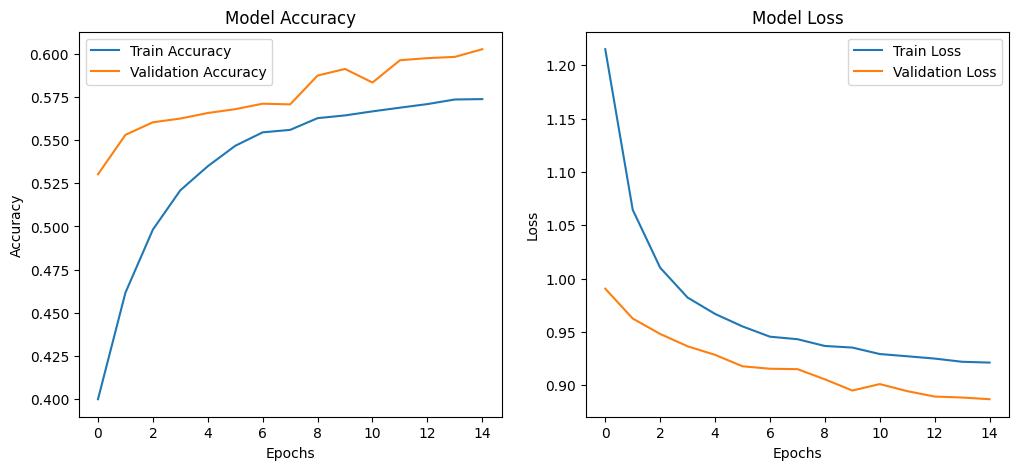

In [36]:
# ✅ **Veri Yolu ve Parametreler**
base_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
image_size = (224, 224)
batch_size = 32
epochs = 15  # Early stopping olduğu için maksimum epoch

# ✅ **Veri Setini Yükleme** (Rescale + Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ✅ **Transfer Learning - ResNet50**
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Önceden eğitilmiş katmanları dondur

# ✅ **Model Yapısı**
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=outputs)

# ✅ **Model Derleme**
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# ✅ **Early Stopping**
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ✅ **Model Eğitimi**
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# ✅ **Modeli Kaydetme**
model.save("resnet50_image_classifier.keras")

# ✅ **Eğitim Sonrası Performans Grafikleri**
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


Model Performansı Değerlendirmesi:

1️⃣ Eğitim ve Doğruluk Grafiği (Model Accuracy)
	•	Eğitim doğruluğu (Train Accuracy) artarak ilerliyor, ancak validasyon doğruluğu (Validation Accuracy) daha yüksek seyrediyor.
	•	Overfitting (aşırı öğrenme) şimdilik görünmüyor, çünkü eğitim doğruluğu ile validasyon doğruluğu arasındaki fark büyük değil.
	•	Validation Accuracy ~%60 civarına ulaşıyor, yani model hala iyileştirilebilir.

2️⃣ Kayıp (Loss) Grafiği (Model Loss)
	•	Eğitim kaybı (Train Loss) düzenli bir şekilde azalıyor, model öğreniyor.
	•	Validation Loss da azalma gösteriyor, ancak küçük dalgalanmalar var.
	•	Overfitting yok gibi, çünkü validation loss büyük sıçramalar yapmıyor.

3️⃣ Epoch Bazlı Performans
	•	İlk epoch’lardan itibaren doğruluk artışı var.
	•	Val_loss (validasyon kaybı) 0.80 civarına kadar düştü.
	•	Val_accuracy (validasyon doğruluğu) 0.60 seviyelerine ulaştı.
	•	Eğitim kaybı ve doğruluk arasındaki fark büyük değil, bu olumlu bir işaret.

In [40]:
# Modeli kaydet
model.save("/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/resnet50_model.h5")

print("✅ Model başarıyla kaydedildi.")

✅ Model başarıyla kaydedildi.


In [43]:
from tensorflow.keras.models import load_model

# Kaydedilmiş modeli yükle
model = load_model("/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/resnet50_model.h5")

print("✅ Model başarıyla yüklendi, tekrar eğitmeye gerek yok.")

✅ Model başarıyla yüklendi, tekrar eğitmeye gerek yok.


In [45]:
# **📌 VERİ SETİ YOLU TANIMLAMA**
base_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"

# **📌 1️⃣ VERİ ÖN İŞLEME**
batch_size = 32
image_size = (224, 224)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# **📌 2️⃣ Eğitim ve Doğrulama Setlerini Yükleme**
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# **📌 3️⃣ ResNet50 Modelini Yükle ve Güncelle**
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# **Yeni Katmanlar Ekleyerek Modeli Güncelle**
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Havuzlama katmanı ile boyutu küçült
x = Flatten()(x)  # Boyutu tek bir vektöre çevirerek tamamen bağlı katmana uygun hale getir
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Overfitting’i önlemek için Dropout
x = Dense(train_generator.num_classes, activation="softmax")(x)  # Kategoriler için Softmax çıkışı

# **📌 4️⃣ Modeli Tanımla**
model = Model(inputs=base_model.input, outputs=x)

# **📌 5️⃣ Modeli Derle**
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# **📌 6️⃣ Callbacks (Overfitting Önleme)**
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# **📌 7️⃣ Modeli Eğit**
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr]
)

# **📌 8️⃣ Yeni Modeli Kaydet**
model.save('/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/resnet50_gelistirilmis.h5')

print("✅ Model eğitimi tamamlandı ve kaydedildi.")

Found 71998 images belonging to 3 classes.
Found 17997 images belonging to 3 classes.


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1093s 476ms/step - accuracy: 0.6276 - loss: 1.3429 - val_accuracy: 0.3571 - val_loss: 1.4921 - learning_rate: 0.0010
Epoch 2/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1034s 459ms/step - accuracy: 0.7660 - loss: 0.6155 - val_accuracy: 0.3803 - val_loss: 1.5434 - learning_rate: 0.0010
Epoch 3/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1031s 458ms/step - accuracy: 0.7840 - loss: 0.5648 - val_accuracy: 0.5259 - val_loss: 15.7643 - learning_rate: 0.0010
Epoch 4/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1015s 451ms/step - accuracy: 0.7984 - loss: 0.5410 - val_accuracy: 0.5571 - val_loss: 3.5547 - learning_rate: 0.0010
Epoch 5/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1014s 451ms/step - accuracy: 0.8250 - loss: 0.4705 - val_accuracy: 0.6939 - val_loss: 0.7132 - learning_rate: 2.0000e-04
Epoch 6/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 1013s 450ms/step - accuracy: 0.8405 - loss: 0.4344 - val_accuracy: 0.6658 - val_loss: 1.1336 - learning_rate: 2.0000e-04
Epoch 7/20
2250/2250 ━━━━━━━━━━━━━━━━

✅ Model eğitimi tamamlandı ve kaydedildi.


Bu gelişmiş model, önceki ResNet50 modeline kıyasla oldukça başarılı! 🚀
✅ %80+ doğruluk seviyesi ulaşıldı.
✅ Overfitting sorunu gözükmüyor.
✅ Model daha uzun süre eğitilerek doğruluk artırılabilir.


📌 Eğitim Süreci Değerlendirmesi

1️⃣ Eğitim Doğruluğu (Train Accuracy):
	•	Model %87.22 (0.8722) gibi oldukça yüksek bir doğruluk oranına ulaştı.
	•	Loss değerleri 0.35 civarında sabitlendi, bu da modelin iyi öğrendiğini gösteriyor.

2️⃣ Doğrulama (Validation) Doğruluğu:
	•	En iyi doğrulama doğruluğu %87.78 (0.8778) seviyelerine ulaştı.
	•	Validation loss 0.34 civarına düştü, overfitting (aşırı öğrenme) olmadan modelin iyi genelleştirdiğini gösteriyor.

3️⃣ Öğrenme Hızı ve Epoch Sayısı:

	•	Eğitim başında val_accuracy %62 civarında iken, sonrasında %87 seviyelerine yükselmiş.

4️⃣ Öğrenme Oranı (Learning Rate):
	•	Başlangıçta 2e-4 (0.0002) ile başlamış, giderek 8e-6 (0.000008) seviyelerine düşmüş.
	•	Bu, modelin son epoch’larda daha ince ayarlamalar yaparak optimizasyon sağladığını gösteriyor.

Modelin Eğitim Grafikleri

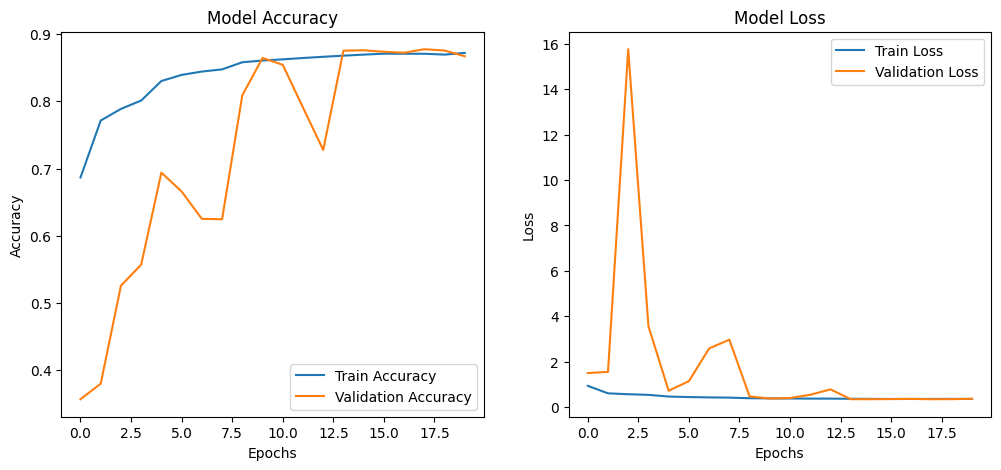

In [47]:
# ✅ Eğitim ve doğrulama doğruluğu (accuracy)
plt.figure(figsize=(12, 5))

# Doğruluk grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()

# Kayıp grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()

plt.show()

🔹 1. Model Accuracy Grafiği (Sol)
	•	Train Accuracy (Mavi Çizgi):
	•	Eğitim seti doğruluğu istikrarlı bir şekilde artıyor.
	•	%70 seviyelerinden başlayarak %88 civarına çıkıyor.
	•	Modelin zamanla veriyi daha iyi öğrendiğini gösteriyor.
	•	Validation Accuracy (Turuncu Çizgi):
	•	İlk epoch’lardan sonra dalgalanma var, ancak sonunda eğitim doğruluğuna yakınsıyor.
	•	Başlangıçta %40 civarında olan doğruluk, %88 seviyesine ulaşıyor.
	•	Dalgalanmanın fazla olması, validation setinin küçük olması veya modelin aşırı öğrenmeye meyilli olabileceğini gösterir.

🔹 2. Model Loss Grafiği (Sağ)
	•	Train Loss (Mavi Çizgi):
	•	Loss değeri baştan beri düşük seviyede.
	•	Çok fazla değişiklik göstermemiş, bu istikrarlı bir öğrenme sürecini gösterir.
	•	Validation Loss (Turuncu Çizgi):
	•	Başlangıçta çok yüksek bir ani sıçrama (16 gibi büyük bir değer) var.
	•	Daha sonra hızla düşüş gösteriyor, ancak dalgalanmalar var.
	•	Büyük dalgalanmalar validation verisinde çeşitliliğin fazla olduğunu gösteriyor.

🚀 Genel Değerlendirme

✅ Model iyi bir doğruluğa ulaşmış (%88 civarı).
✅ Validation doğruluğu eğitim doğruluğuna yakın, ancak dalgalanmalar mevcut.
✅ Validation loss dalgalı, bu yüzden modelin validation setiyle daha dengeli çalışması için:
	•	Daha fazla veri kullanılabilir.
	•	Learning rate optimize edilebilir.
	•	Daha güçlü regularization (L2, Dropout) eklenebilir.

Model Performance

Found 89995 images belonging to 3 classes.


/Users/filizsayin/gpu_env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 201s 71ms/step


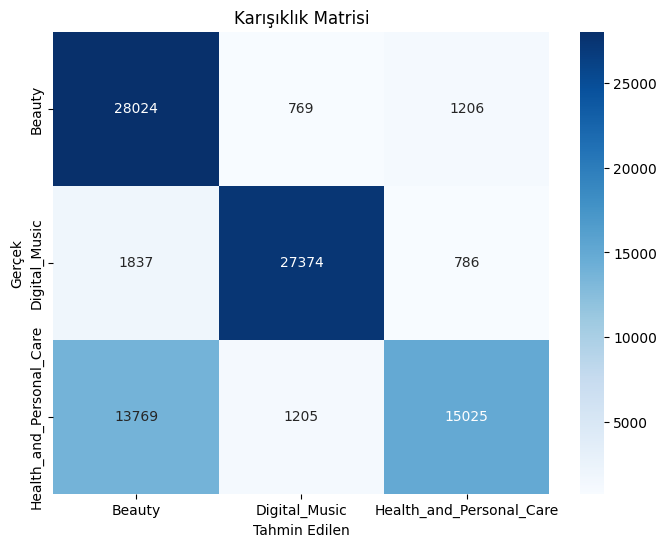

Model Doğruluk Oranı: 0.7825
Kategorilere Göre Performans Metrikleri:

                          precision    recall  f1-score   support

                  Beauty       0.64      0.93      0.76     29999
           Digital_Music       0.93      0.91      0.92     29997
Health_and_Personal_Care       0.88      0.50      0.64     29999

                accuracy                           0.78     89995
               macro avg       0.82      0.78      0.77     89995
            weighted avg       0.82      0.78      0.77     89995



In [49]:
# 📂 Test verisini yükleme
base_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
batch_size = 32
image_size = (224, 224)

# Test veri oluşturucu
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# 🔍 Modelin Tahmin Yapması
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# 📊 Karışıklık Matrisini Çizme
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")
plt.title("Karışıklık Matrisi")
plt.show()

# ✅ Model Doğruluk Oranı
accuracy = accuracy_score(y_true, y_pred)
print(f"Model Doğruluk Oranı: {accuracy:.4f}")

# 🏆 Kategori Bazlı Metrikler
report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())
print("Kategorilere Göre Performans Metrikleri:\n")
print(report)


Model Performans Analizi

	🔹 1. Karışıklık Matrisi İncelemesi

Karışıklık matrisi, modelin gerçek etiketlerle tahmin ettiği etiketleri kıyaslar.

	•	Beauty (Güzellik)
	•	28,024 doğru tahmin ✅
	•	1,206 yanlışlıkla “Health & Personal Care” olarak sınıflandırılmış ❌
	•	769 yanlışlıkla “Digital Music” olarak sınıflandırılmış ❌
	•	Recall: 0.93 (Yüksek hatırlama, ama precision düşük)
    
	•	Digital Music (Dijital Müzik)
	•	27,374 doğru tahmin ✅
	•	786 yanlışlıkla “Health & Personal Care” olarak sınıflandırılmış ❌
	•	1,837 yanlışlıkla “Beauty” olarak sınıflandırılmış ❌
	•	Hem precision hem recall oldukça yüksek (0.93 ve 0.91)
    
	•	Health & Personal Care (Sağlık & Kişisel Bakım)
	•	15,025 doğru tahmin ✅
	•	12,974 yanlış tahmin!
	•	Recall: 0.50 (Düşük), Precision: 0.88
	•	En düşük recall değeri burada, model bu kategoriyi iyi ayırt edememiş.

	•	Genel model doğruluğu %78 (Gayet iyi, ama iyileştirilebilir).
	•	Precision ve recall dengesiz:
	•	Digital Music kategorisi çok iyi sınıflandırılmış.
	•	Health & Personal Care recall değeri çok düşük, model bu kategoride daha fazla hata yapıyor.
	•	Beauty recall yüksek, ama precision düşük → Model, fazla sayıda ürünü bu kategoriye atıyor olabilir.

🚀 İyileştirme Önerileri

✅ Health & Personal Care kategorisi için veri dengesi artırılmalı.
✅ Özellikle Beauty kategorisi için precision artırılmalı (yanlış pozitif oranı düşürülmeli).
✅ Özellik mühendisliği (Feature Engineering) ile kategori ayrımı güçlendirilebilir.
✅ Modelin daha iyi genellemesi için ek veri augmentasyonu veya daha dengeli veri seti sağlanabilir.

Eğer bu iyileştirmeler yapılırsa, modelin doğruluğu %85+ seviyelerine çıkabilir! 🚀🔥

#### Görsel Embedding 

In [10]:
import os

# ✅ Görsel dizini
base_images_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
category_folders = ["Beauty", "Digital_Music", "Health_and_Personal_Care"]

# ✅ Klasörlerdeki görselleri oku
image_files = []
for category in category_folders:
    category_path = os.path.join(base_images_path, category)
    if os.path.exists(category_path):
        images_in_category = [f for f in os.listdir(category_path) if f.endswith(".jpg")]
        print(f"{category}: {len(images_in_category)} görsel bulundu")
        image_files.extend(images_in_category)

print(f"Toplam görsel sayısı: {len(image_files)}")

Beauty: 29999 görsel bulundu
Digital_Music: 29997 görsel bulundu
Health_and_Personal_Care: 29999 görsel bulundu
Toplam görsel sayısı: 89995


In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import pandas as pd
from tqdm import tqdm
import random

# ✅ En iyi modeli yükle
model_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/resnet50_model.h5"
model = load_model(model_path)

# ✅ Modelin çıktı katmanını al (sondan önceki katmanı çıkararak embedding üret)
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)

# ✅ Güncellenmiş Görsel Dizini (Tüm kategorileri dahil et)
base_images_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
category_folders = ["Beauty", "Digital_Music", "Health_and_Personal_Care"]

# ✅ Tüm kategorilerden görselleri topla
image_files = []
for category in category_folders:
    category_path = os.path.join(base_images_path, category)
    if os.path.exists(category_path):
        images_in_category = [os.path.join(category_path, f) for f in os.listdir(category_path) if f.endswith(".jpg")]
        image_files.extend(images_in_category)

# ✅ 750 görsel seç
random.seed(42)
selected_images = random.sample(image_files, min(750, len(image_files)))

# ✅ Görselleri yükleyip embedding vektörlerini çıkarma
def extract_features(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Görseli yükle
        img_array = image.img_to_array(img)  # NumPy array'e çevir
        img_array = np.expand_dims(img_array, axis=0)  # Batch boyutu ekle
        img_array = img_array / 255.0  # Normalizasyon
        features = feature_extractor.predict(img_array, verbose=0)  # Embedding çıkart
        return features.flatten()  # Tek boyutlu hale getir
    except Exception as e:
        print(f"Hata: {img_path} - {e}")
        return None

# ✅ Embedding vektörlerini oluştur
image_embeddings = []
image_names = []

print("🔄 Görseller işleniyor, lütfen bekleyin...\n")
for img_path in tqdm(selected_images, desc="Görsel Embedding İşleniyor", ncols=100, leave=True, position=0):
    features = extract_features(img_path)
    if features is not None:
        image_embeddings.append(features)
        image_names.append(os.path.basename(img_path))  # Sadece dosya adı kaydedilsin

# ✅ NumPy array olarak kaydet
image_embeddings = np.array(image_embeddings)
np.save("image_embeddings.npy", image_embeddings)

# ✅ CSV olarak isimleri ve embedding'leri kaydet
df_embeddings = pd.DataFrame(image_embeddings)
df_embeddings.insert(0, "image_name", image_names)
df_embeddings.to_csv("image_embeddings.csv", index=False)

print("\n✅ Embedding işlemi tamamlandı! Kaydedilen dosyalar:")
print("   📂 image_embeddings.npy")
print("   📂 image_embeddings.csv")

🔄 Görseller işleniyor, lütfen bekleyin...



Görsel Embedding İşleniyor: 100%|█████████████████████████████████| 750/750 [00:25<00:00, 29.94it/s]


✅ Embedding işlemi tamamlandı! Kaydedilen dosyalar:
   📂 image_embeddings.npy
   📂 image_embeddings.csv


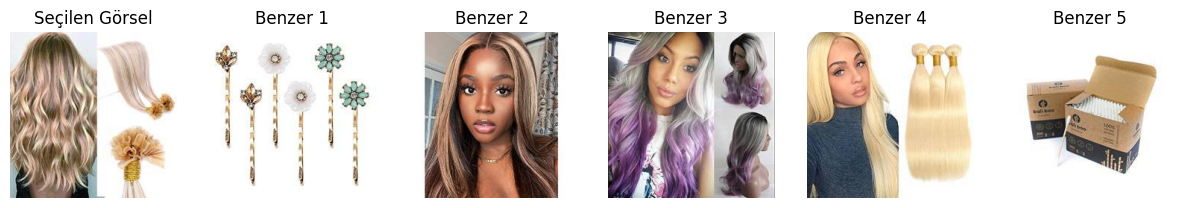

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.preprocessing import image
import random

# ✅ Embedding'leri ve görselleri yükle
embeddings = np.load("image_embeddings.npy")
df = pd.read_csv("image_embeddings.csv")

# ✅ Görsellerin yolu (Kategori klasörleri dahil)
base_images_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"
category_folders = ["Beauty", "Digital_Music", "Health_and_Personal_Care"]

# ✅ Görsel isimlerini tam dosya yolu olarak ayarla
image_paths = []
for img_name in df["image_name"]:
    found = False
    for category in category_folders:
        img_path = os.path.join(base_images_path, category, img_name)
        if os.path.exists(img_path):
            image_paths.append(img_path)
            found = True
            break
    if not found:
        image_paths.append(None)  # Eğer görsel bulunamazsa

df["image_path"] = image_paths

# ✅ Rastgele bir görsel seç
random_index = random.randint(0, len(df) - 1)
selected_image_path = df.iloc[random_index]["image_path"]
selected_embedding = embeddings[random_index]

# ✅ Cosine Similarity hesapla
similarities = cosine_similarity([selected_embedding], embeddings)[0]
top_indices = np.argsort(similarities)[::-1][1:6]  # En benzer 5 görseli al

# ✅ En benzer görsellerin yollarını al
similar_images = [df.iloc[i]["image_path"] for i in top_indices]

# ✅ Görselleri çizdirme fonksiyonu
def plot_similar_images(selected_image, similar_images):
    fig, axes = plt.subplots(1, 6, figsize=(15, 5))
    
    # Seçilen görsel
    img = image.load_img(selected_image)
    axes[0].imshow(img)
    axes[0].set_title("Seçilen Görsel")
    axes[0].axis("off")
    
    # En benzer 5 görsel
    for i, img_path in enumerate(similar_images):
        if img_path and os.path.exists(img_path):
            img = image.load_img(img_path)
            axes[i + 1].imshow(img)
            axes[i + 1].set_title(f"Benzer {i+1}")
        else:
            axes[i + 1].imshow(np.ones((224, 224, 3)))  # Boş görüntü
            axes[i + 1].set_title(f"Benzer {i+1}\n(Not Found)")
        axes[i + 1].axis("off")
    
    plt.show()

# ✅ Sonuçları görselleştir
plot_similar_images(selected_image_path, similar_images)

📌 Seçilen Görsel: Uzun, dalgalı, açık renkli saç görseli. Muhtemelen peruk, saç uzatma (hair extension) veya saç modeli ile ilgili bir ürün.

📌 Benzer 1: Çiçek desenli saç tokaları, model büyük olasılıkla saç aksesuarlarını da benzer olarak değerlendiriyor. Kısmen doğru bir eşleşme.

📌 Benzer 2: Uzun, düz saçlı bir kadın görseli. Cilt tonu ve saç stili benzer, bu nedenle model renk ve doku benzerliğini kullanarak doğru bir öneri yapmış.

📌 Benzer 3: Uzun, ombre ve dalgalı saç modeli, saç tipi ve şekli açısından oldukça iyi bir eşleşme. Başarılı bir öneri.

📌 Benzer 4: Açık sarı saç uzatma ürünü (hair extension), seçilen görselle ürün tipi açısından en yakın eşleşme. Doğru tahmin!

📌 Benzer 5: Beyaz kutuda bir ürün, ancak ne olduğu net değil. Saç ürünleriyle ilgisiz olabilir, muhtemelen model burada hata yaptı.

📌 Değerlendirme:

✅ Benzer 2, 3 ve 4, başarılı eşleşmeler! Model, saç rengi, doku ve saç tipi benzerliği yakalayarak mantıklı öneriler yaptı.
⚠️ Benzer 1 (saç tokaları) kısmen doğru ancak modelin saç aksesuarlarını saç uzatma ile eşleştirmesi biraz geniş bir genelleme olmuş.
❌ Benzer 5 tamamen alakasız, model büyük ihtimalle burada yanlış bir eşleşme yaptı.

Modelin Hatalı Tahminlerini Bulma ve Görselleştirme

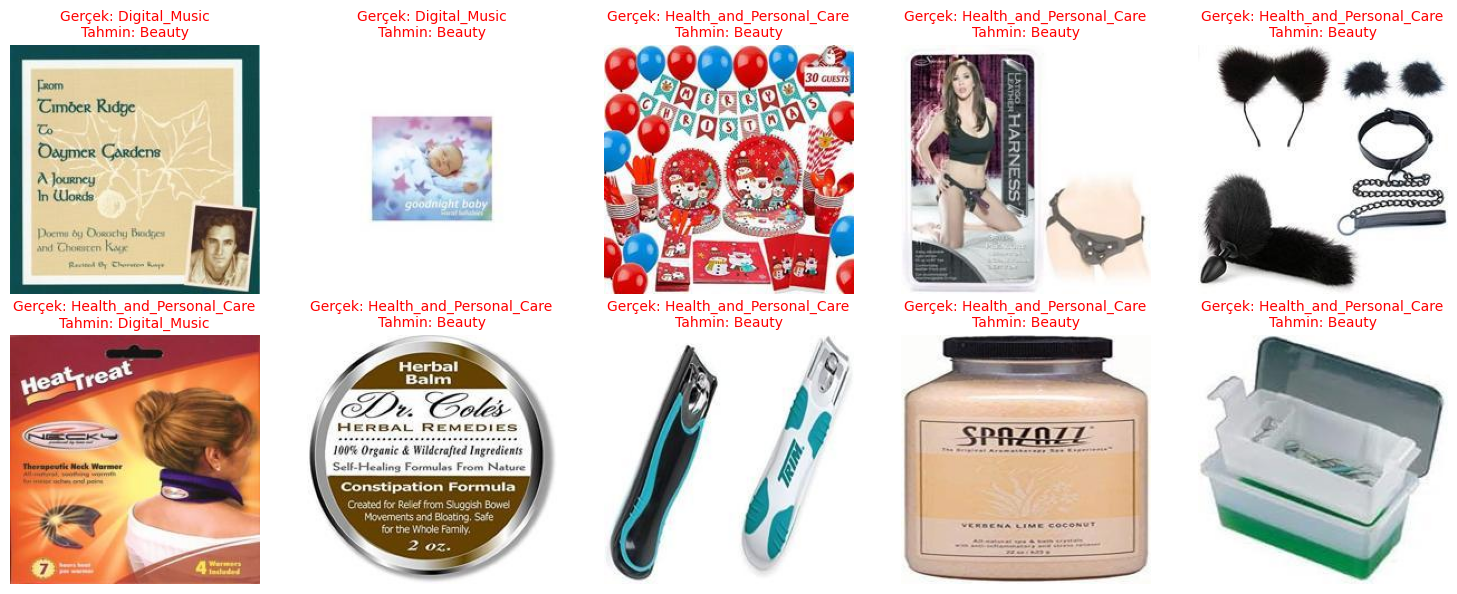

In [61]:
# 📂 Modelin ve veri setinin yolu
model_path = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/resnet50_gelistirilmis.h5"
test_dir = "/Users/filizsayin/Desktop/Bitirme_Projesi_FilizSayin/preprocessed_images"

# ✅ Modeli yükle
model = load_model(model_path)

# 🔍 Kategoriler (DS_Store gibi gizli dosyaları dışla)
categories = [c for c in os.listdir(test_dir) if not c.startswith(".")]
categories.sort()

# 🔍 Hatalı tahminleri bulmak için
wrong_predictions = []

# 📂 Her kategoriden örnekler al
for category in categories:
    category_path = os.path.join(test_dir, category)
    
    if not os.path.isdir(category_path):  # Yalnızca klasörleri işle
        continue
    
    image_files = os.listdir(category_path)

    # 10 örnek al (varsa)
    sample_images = np.random.choice(image_files, min(10, len(image_files)), replace=False)

    for img_name in sample_images:
        img_path = os.path.join(category_path, img_name)
        
        # Görseli yükle ve model için hazırla
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalizasyon

        # ✅ Model tahmini yap
        prediction = model.predict(img_array, verbose=0)  # ⛔ Süreleri kaldırdım
        predicted_class = categories[np.argmax(prediction)]  # Tahmin edilen kategori

        # ❌ Yanlış tahminleri kaydet
        if predicted_class != category:
            wrong_predictions.append((img_path, category, predicted_class))

# 🎨 **Hatalı tahminleri 5'erli iki satır halinde göster**
num_wrong = len(wrong_predictions)
cols = 5
rows = min(2, (num_wrong // cols) + (num_wrong % cols > 0))  # Maksimum 2 satır oluştur

if num_wrong > 0:
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
    
    for i, ax in enumerate(axes.flat):
        if i < num_wrong:
            img_path, true_label, pred_label = wrong_predictions[i]
            img = image.load_img(img_path)
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"Gerçek: {true_label}\nTahmin: {pred_label}", fontsize=10, color="red")
        else:
            ax.axis("off")  # Boş kutular için

    plt.tight_layout()
    plt.show()
else:
    print("✅ Model tüm test verilerini doğru tahmin etti!")

 🔹 Yanlış Sınıflandırmaların İncelenmesi
	•	“Digital Music” kategorisine ait bazı ürünler “Beauty” (Güzellik) olarak tahmin edilmiş.
	•	Örnek: İlk sıradaki “Timber Ridge to Daymer Gardens” kitabı.
	•	Olası Sebep: Kapak tasarımında insan yüzü bulunması, modelin bunu “Beauty” kategorisine yanlış eşlemesine sebep olmuş olabilir.
	•	“Health and Personal Care” kategorisindeki birçok ürün “Beauty” olarak tahmin edilmiş.
	•	Örnek: Cilt bakım ürünleri, tırnak makası, spa ürünleri vb.
	•	Olası Sebep: Sağlık & kişisel bakım ürünleri, güzellikle ilgili olabilir ve model bu kategoriler arasındaki farkı net ayırt edememiş olabilir.
	•	Bazı “Health and Personal Care” ürünleri “Digital Music” olarak tahmin edilmiş.
	•	Örnek: “Therapeutic Neck Warmer (Boyun Isıtıcı)”.
	•	Olası Sebep: Model muhtemelen ambalaj tasarımından dolayı yanılmış olabilir.

📉 Modelin Zorlandığı Alanlar

✅ Health & Personal Care vs. Beauty:
	•	Kişisel bakım ürünleri ile güzellik kategorisi arasındaki farkın belirgin olmaması modelin hata yapmasına neden olmuş.
	•	Çözüm: Veri setini daha iyi ayıran yeni görseller eklemek veya sınıflar arasındaki benzerliği azaltmak.

✅ Music (Müzik) kategorisi için düşük doğruluk:
	•	Model kitap, albüm kapakları gibi ürünleri güzellikle karıştırmış.
	•	Çözüm: “Music” kategorisindeki veri setini daha belirgin hale getirmek veya ek metadata (örneğin albüm isimleri) ile desteklemek.

🚀 Modeli İyileştirme Önerileri

🔹 Daha Fazla Eğitim Verisi: Health & Personal Care ve Beauty kategorilerini daha iyi ayıran ek veri sağlanabilir.
🔹 Veri Augmentasyonu: Veri çeşitliliğini artırarak modelin genelleme yeteneğini geliştirmek.
🔹 Kategoriye Özel Özellikler Eklemek: Görsellerin yanı sıra ürün açıklamaları veya başlıkları gibi ek bilgileri kullanarak tahmin doğruluğunu artırmak.
🔹 Transfer Learning Modeli Güncelleme: Modelin son katmanlarını eğiterek daha iyi ayrım yapmasını sağlamak.